## Character recognition 

This demo extends the kaggle [competition](https://www.kaggle.com/c/street-view-getting-started-with-julia/details/julia-tutorial). In this demo, we train using images of characters obtained from google view, and also classify test images which are of various sizes. Firstly k-Nearest Neighbor is used to identify the characters. Some of the take aways are how easy it is to build parallelizable and fast systems. We also try out various other methods and show comparisons. 

#### Some key takeaways:
* Ease of prototyping deployable models. 
* Parallelization also very easy to implement. 
* For loops are so fast in Julia.
* How to gain from vectorizations.

Download the following files from [here](https://www.kaggle.com/c/street-view-getting-started-with-julia/data), and place them in the /data directory :

* testResized/
* trainResized/
* sampleSubmission.csv
* trainLabels.csv

In [5]:
using Images, Colors, DataFrames, TestImages, Gadfly

In [2]:
include("$(Pkg.dir())/MLDemos/src/characters/knndemo.jl")

In [3]:
# Some configurations
path = "$(Pkg.dir())/MLDemos/";
imageSize = 400;
# Read the training labels
labelsInfoTrain = readtable("$(path)data/characters/trainLabels.csv");
# Read the test labels
labelsInfoTest = readtable("$(path)data/characters/testLabels.csv");

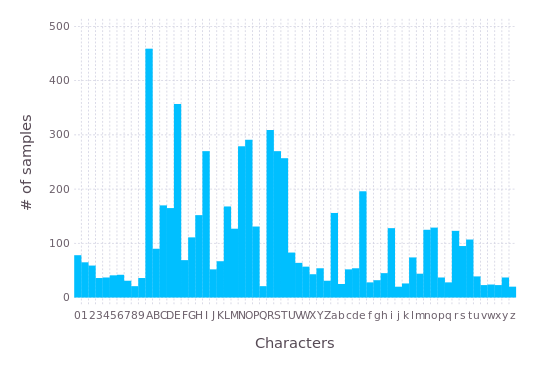

In [6]:
#chars=unique(labelsInfoTrain[:Class])
counts=by(labelsInfoTrain, :Class, nrow)
p1 = Gadfly.plot(x = counts[:Class], y=counts[:x1], Guide.xlabel("Characters"), Guide.ylabel("# of samples"), Geom.bar)



 The training images range 1.Bmp to 6283.Bmp, Lets see how the characters look like:

In [108]:
function showimtrain(image::Int64)
    testimage(joinpath("$(path)/data/characters/trainResized/$image.Bmp"))
end

showimtrain (generic function with 1 method)

In [22]:
n=345
labelsInfoTrain[n,:Class]

"S"

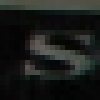

In [23]:
showim(n)

In [12]:
#read the images in from the training data.
xTrain = read_data_sv("train", labelsInfoTrain, imageSize, "$(path)data/characters");

#read the test images
xTest = read_data_sv("test", labelsInfoTest, imageSize, "$(path)data/characters");


 in depwarn at deprecated.jl:73
 in imread at deprecated.jl:50
 in read_data_sv at /home/abhijithc/.julia/v0.4/MLDemos/src/characters/knndemo.jl:16
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/abhijithc/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /home/abhijithc/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[12], in expression starting on line 2


In [16]:
#Map the training characters to ASCII values
yTrain = map(x -> x[1], labelsInfoTrain[:Class]);
yTrain = int(yTrain);

 in depwarn at deprecated.jl:73
 in int at deprecated.jl:50
 in int at deprecated.jl:282
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/abhijithc/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /home/abhijithc/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[16], in expression starting on line 3


In [17]:
xTrain = xTrain'
xTest = xTest'

400x6220 Array{Float64,2}:
 0.45098   0.282353  0.113725  0.592157  …  0.329412  0.635294  0.403922
 0.447059  0.286275  0.152941  0.545098     0.341176  0.611765  0.423529
 0.443137  0.309804  0.156863  0.564706     0.345098  0.662745  0.396078
 0.443137  0.301961  0.156863  0.529412     0.345098  0.635294  0.388235
 0.435294  0.309804  0.156863  0.568627     0.341176  0.627451  0.368627
 0.431373  0.341176  0.156863  0.607843  …  0.341176  0.615686  0.368627
 0.458824  0.34902   0.160784  0.568627     0.345098  0.611765  0.411765
 0.462745  0.333333  0.160784  0.576471     0.337255  0.619608  0.501961
 0.447059  0.341176  0.160784  0.537255     0.337255  0.643137  0.690196
 0.462745  0.364706  0.156863  0.560784     0.341176  0.654902  0.819608
 0.458824  0.364706  0.156863  0.580392  …  0.345098  0.627451  0.858824
 0.458824  0.376471  0.156863  0.592157     0.337255  0.65098   0.862745
 0.458824  0.388235  0.156863  0.592157     0.345098  0.631373  0.796078
 ⋮                      

In [102]:
addprocs(1)
@everywhere using DataFrames
include("$(Pkg.dir())/MLDemos/src/characters/knndemo.jl")
procs()

4-element Array{Int64,1}:
  1
 31
 32
 33

In [99]:
#rmprocs([22,23,24,25,26,27,28,29,30])
procs()

2-element Array{Int64,1}:
  1
 31

In [103]:
# Assign the labels to the training images and find the ratio
# of correctly classified labels to the total number of labels

k = 3
@time sumValues = @parallel (+) for i in 1:size(xTrain, 2)
 assign_label(xTrain, yTrain, k, i) == yTrain[i, 1]
end
loofCvAccuracy = sumValues / size(xTrain, 2)

 17.179529 seconds (5.79 k allocations: 553.861 KB)


0.04918032786885246

In [104]:
# Running the kNN on test data set
tic()
k = 3 # The CV accuracy shows this value to be the best.                             
yPredictions = @parallel (vcat) for i in 1:size(xTest, 2)
 nRows = size(xTrain, 1)
 imageI = Array(Float32, nRows)
 for index in 1:nRows
  imageI[index] = xTest[index, i]
 end
 assign_label(xTrain, yTrain, k, imageI)
end
toc()

elapsed time: 31.439186985 seconds


31.439186985

In [109]:
function showimtest(image::Int64)
    testimage(joinpath("$(path)/data/characters/testResized/$image.Bmp"))
end

showimtest (generic function with 1 method)

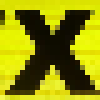

In [112]:
showimtest(6302)

In [107]:
labelsInfoTest

,ID,Class
1,6284,H
2,6285,E
3,6286,R
4,6287,d
5,6288,E
6,6289,C
7,6290,0
8,6291,a
9,6292,8
10,6293,H


In [106]:
#Convert integer predictions to character                                            
labelsInfoTest[:Class] = char(yPredictions)

 in depwarn at deprecated.jl:73
 in char at deprecated.jl:50
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/abhijithc/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /home/abhijithc/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[106], in expression starting on line 2


6220-element Array{Char,1}:
 'H'
 'E'
 'R'
 'd'
 'E'
 'C'
 '0'
 'a'
 '8'
 'H'
 'N'
 'R'
 'k'
 ⋮  
 'R'
 '4'
 'S'
 'G'
 'e'
 'I'
 'L'
 'O'
 'o'
 'M'
 'X'
 'e'

In [22]:
#Save predictions                                                                    
writetable("$(path)/data/juliaKNNSubmission.csv", labelsInfoTest, separator=',', header=true)

In [ ]:
@show predictions = readtable("$(path)/data/juliaKNNSubmission.csv")